# 1. 2D Patch Extraction from 3D Volume NOISY

In [1]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segyio
import os
import pandas as pd

In [3]:
filePath_noisy = '/home/roderickperez/DS_projects/autoencoders/data/InforPetrol/seismicOriginal/InfoP_noisy.segy'

### Load Noisy Dataset

In [4]:
with segyio.open(filePath_noisy, mode = "r", iline = 189, xline = 193) as s:
    cubeNoisy = segyio.cube(s)

In [5]:
cubeNoisy.shape

(351, 4097, 1751)

---

In [6]:
# Select a random value for the inline, crossline, time slice
iline = np.random.randint(0, cubeNoisy.shape[0])
xline = np.random.randint(0, cubeNoisy.shape[1])
time = np.random.randint(0, cubeNoisy.shape[2])

---

In [7]:
amplitude_max = np.percentile(cubeNoisy, 98)
amplitude_max

7.233442306518555

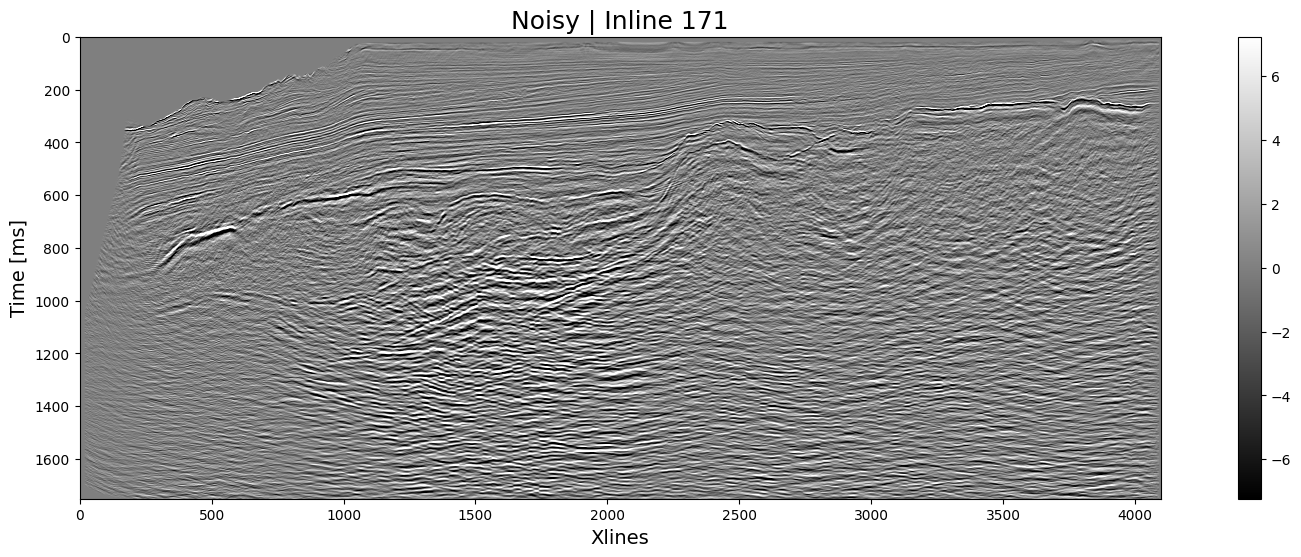

In [8]:
# Visualize the inline
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Inline %d' %iline, fontsize = 18)
plt.savefig('/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/Noisy_Inline_%d.png' %iline)
plt.show()

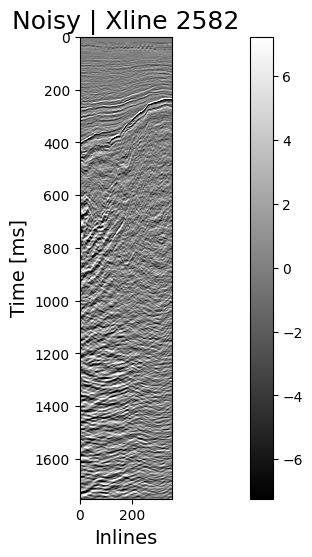

In [9]:
# Visualize the crossline
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[:, xline, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Xline %d' %xline, fontsize = 18)
plt.savefig('/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/Noisy_Xline_%d.png' %xline)
plt.show()

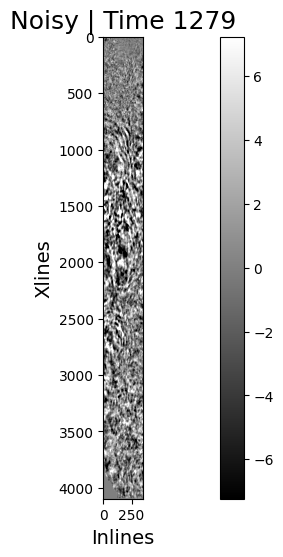

In [10]:
# Visualize the time slice
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[:, :, time].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.colorbar()
plt.xlabel('Inlines', fontsize = 14)
plt.ylabel('Xlines', fontsize = 14)
plt.title('Noisy | Time %d' %time, fontsize = 18)
plt.savefig('/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/Noisy_Xline_%d.png' %time)
plt.show()

---

Compose image

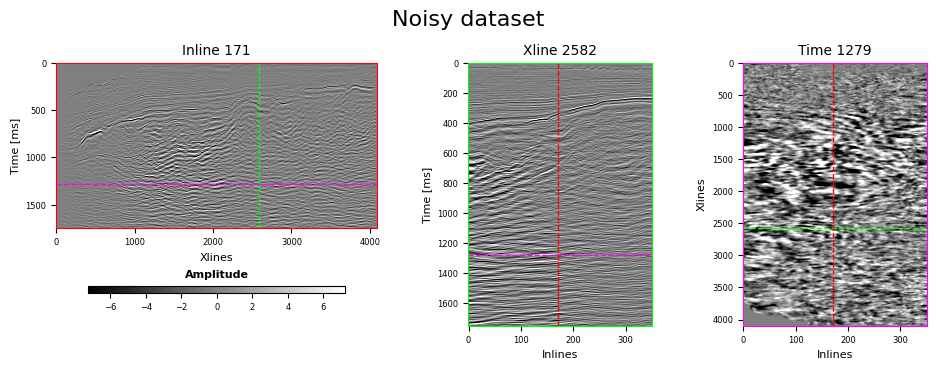

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(3,7,(1, 17))
# Change the frame color to red
ax = plt.gca()
ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('red')
ax.spines['right'].set_color('red')
ax.spines['left'].set_color('red')

plt.imshow(cubeNoisy[iline, :, :].T, aspect = 'auto', cmap = 'gray', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 8)
plt.ylabel('Time [ms]', fontsize = 8)
plt.title('Inline %d' %iline, fontsize = 10)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)

plt.axhline(y = time, color = 'magenta', linestyle = '--', linewidth = 1)
plt.axvline(x = xline, color = 'lime', linestyle = '--', linewidth = 1)

cb = plt.colorbar(orientation='horizontal', pad = 0.22, shrink = 0.8, aspect = 40)

cb.ax.set_title('Amplitude', fontsize=8, weight='bold')
cb.ax.tick_params(labelsize=6)

plt.subplot(3,7,(4, 19))
ax = plt.gca()
ax.spines['bottom'].set_color('lime')
ax.spines['top'].set_color('lime')
ax.spines['right'].set_color('lime')
ax.spines['left'].set_color('lime')

plt.imshow(cubeNoisy[:, xline, :].T, aspect = 'auto', cmap = 'gray', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Inlines', fontsize = 8)
plt.ylabel('Time [ms]', fontsize = 8)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.title('Xline %d' %xline, fontsize = 10)
plt.axhline(y = time, color = 'magenta', linestyle = '--', linewidth = 1)
plt.axvline(x = iline, color = 'red', linestyle = '--', linewidth = 1)


plt.subplot(3,7,(6, 21))
ax = plt.gca()
ax.spines['bottom'].set_color('magenta')
ax.spines['top'].set_color('magenta')
ax.spines['right'].set_color('magenta')
ax.spines['left'].set_color('magenta')

plt.imshow(cubeNoisy[:, :, time].T, aspect = 'auto' , cmap = 'gray', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Inlines', fontsize = 8)
plt.ylabel('Xlines', fontsize = 8)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.title('Time %d' %time, fontsize = 10)
plt.axhline(y = xline, color = 'lime', linestyle = '--', linewidth = 1)
plt.axvline(x = iline, color = 'red', linestyle = '--', linewidth = 1)

plt.tight_layout(pad=3)
plt.suptitle('Noisy dataset', fontsize = 16)
plt.show()

---

### Visualize Patches

In [12]:
patchSizeList = [50, 100, 150, 200]

In [13]:
num_patches = []
total_num_patches = []

for i in patchSizeList:
    iline_num_patch = cubeNoisy.shape[0] // i 
    xline_num_patch = cubeNoisy.shape[1] // i 
    time_num_patch = cubeNoisy.shape[2] // i

    total_num_iline_patches = xline_num_patch*time_num_patch*cubeNoisy.shape[0]
    total_num_xline_patches = iline_num_patch*time_num_patch*cubeNoisy.shape[1]
    total_num_time_patches = iline_num_patch*xline_num_patch*cubeNoisy.shape[2]

    # Concatenate the number of patches
    num_patch = [iline_num_patch, xline_num_patch, time_num_patch]
    total_num_patch = [total_num_iline_patches, total_num_xline_patches, total_num_time_patches]

    # Add to num_patch array
    num_patches.append(num_patch)
    total_num_patches.append(total_num_patch)

    # Convert to dataframe
    num_patches_df = pd.DataFrame(num_patches, columns = ['Inline', 'Xline', 'Time'])
    total_num_patches_df = pd.DataFrame(total_num_patches, columns = ['Inline', 'Xline', 'Time'])


In [14]:
# Add patchSizeList as a new colomn num_patches_df and total_num_patches_df
num_patches_df['Patch Size'] = patchSizeList
total_num_patches_df['Patch Size'] = patchSizeList

In [15]:
# Remove index column
num_patches_df = num_patches_df.set_index('Patch Size')
total_num_patches_df = total_num_patches_df.set_index('Patch Size')

In [16]:
num_patches_df

Inline  Xline  Time
Patch Size                     
50               7     81    35
100              3     40    17
150              2     27    11
200              1     20     8

In [17]:
total_num_patches_df

Inline    Xline    Time
Patch Size                         
50          995085  1003765  992817
100         238680   208947  210120
150         104247    90134   94554
200          56160    32776   35020

Visualize patches with different sizes

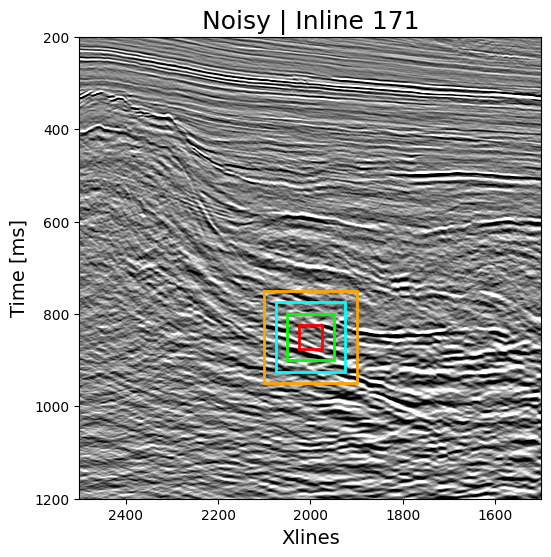

In [18]:
# Visualize the inline
plt.figure(figsize=(20, 6))
plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Inline %d' %iline, fontsize = 18)
plt.xlim(2500, 1500)
plt.ylim(1200, 200)

color_frames = ['red', 'lime', 'cyan', 'orange', 'magenta', 'blue']

for i in patchSizeList:
    rect = patches.Rectangle((2000-(i/2), 850-(i/2)), i, i, linewidth=2.0, edgecolor=color_frames[0], facecolor='none')
    plt.gca().add_patch(rect)
    color_frames = color_frames[1:]

plt.show()

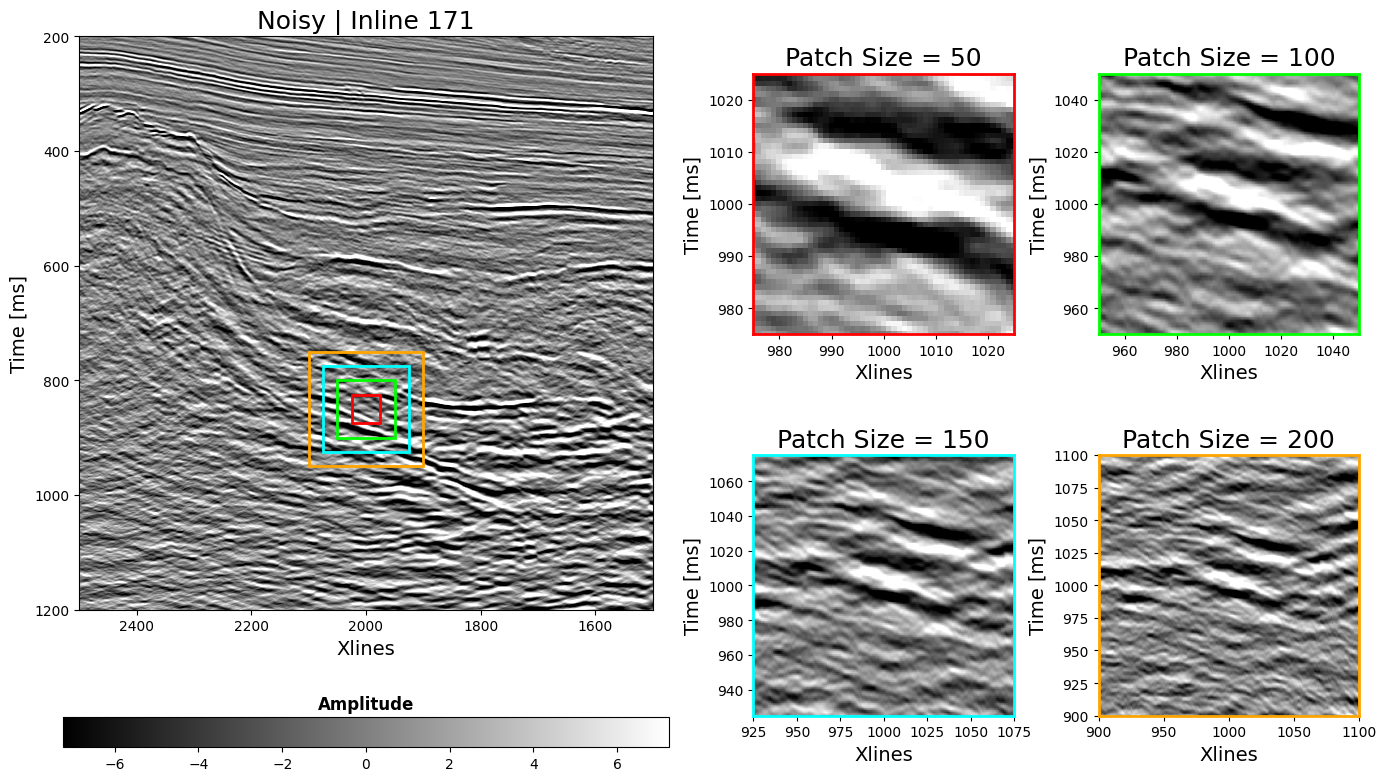

In [19]:
plt.figure(figsize=(14,8))

plt.subplot(2,4,(1, 6))
plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Noisy | Inline %d' %iline, fontsize = 18)
plt.xlim(2500, 1500)
plt.ylim(1200, 200)

color_frames = ['red', 'lime', 'cyan', 'orange']

for i in patchSizeList:
    rect = patches.Rectangle((2000-(i/2), 850-(i/2)), i, i, linewidth=2.0, edgecolor=color_frames[0], facecolor='none')
    plt.gca().add_patch(rect)
    color_frames = color_frames[1:]

# Add horizontal colorbar
cb = plt.colorbar(orientation='horizontal', pad = 0.15, fraction = 0.05)
cb.ax.set_title('Amplitude', fontsize=12, weight='bold')
cb.ax.tick_params(labelsize=10)


plt.subplot(2,4,3)
ax = plt.gca()
ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('red')
ax.spines['right'].set_color('red')
ax.spines['left'].set_color('red')
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Patch Size = 50', fontsize = 18)
plt.xlim((2500 - 1500)-(50/2), (2500 - 1500)+(50/2))
plt.ylim((1200-200)-(50/2), (1200-200)+(50/2))

plt.subplot(2,4,4)
ax = plt.gca()
ax.spines['bottom'].set_color('lime')
ax.spines['top'].set_color('lime')
ax.spines['right'].set_color('lime')
ax.spines['left'].set_color('lime')

ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Patch Size = 100', fontsize = 18)
plt.xlim((2500 - 1500)-(100/2), (2500 - 1500)+(100/2))
plt.ylim((1200-200)-(100/2), (1200-200)+(100/2))

plt.subplot(2,4,7)
ax = plt.gca()
ax.spines['bottom'].set_color('cyan')
ax.spines['top'].set_color('cyan')
ax.spines['right'].set_color('cyan')
ax.spines['left'].set_color('cyan')

ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Patch Size = 150', fontsize = 18)
plt.xlim((2500 - 1500)-(150/2), (2500 - 1500)+(150/2))
plt.ylim((1200-200)-(150/2), (1200-200)+(150/2))

plt.subplot(2,4,8)
ax = plt.gca()
ax.spines['bottom'].set_color('orange')
ax.spines['top'].set_color('orange')
ax.spines['right'].set_color('orange')
ax.spines['left'].set_color('orange')

ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

plt.imshow(cubeNoisy[iline, :, :].T, cmap = 'gray', aspect='equal', vmin = -amplitude_max, vmax = amplitude_max)
plt.xlabel('Xlines', fontsize = 14)
plt.ylabel('Time [ms]', fontsize = 14)
plt.title('Patch Size = 200', fontsize = 18)
plt.xlim((2500 - 1500)-(200/2), (2500 - 1500)+(200/2))
plt.ylim((1200-200)-(200/2), (1200-200)+(200/2))

plt.tight_layout()
plt.show()


---

### Extract Patches

#### Inline

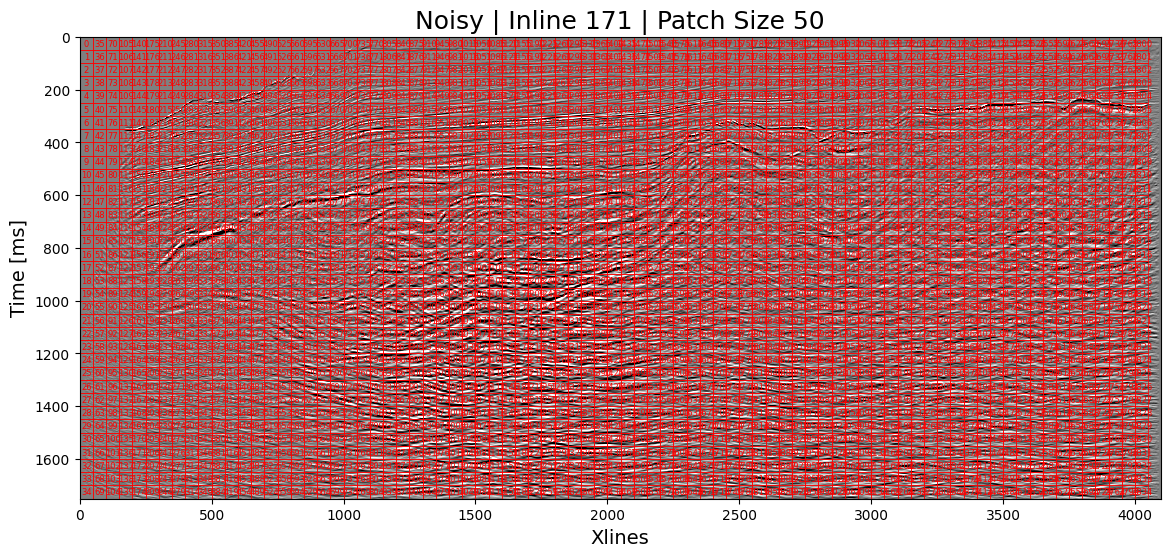

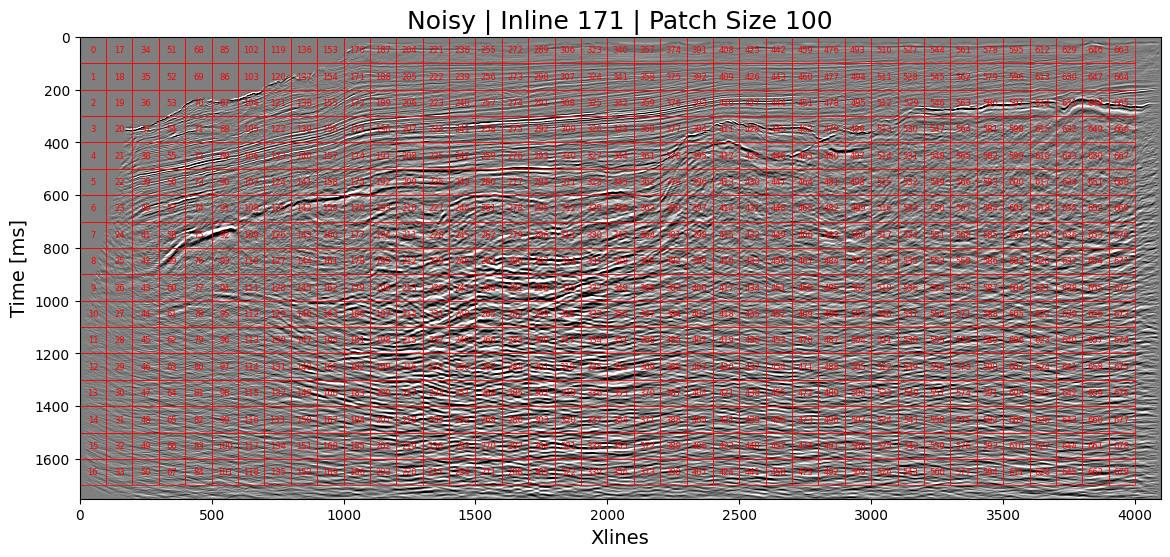

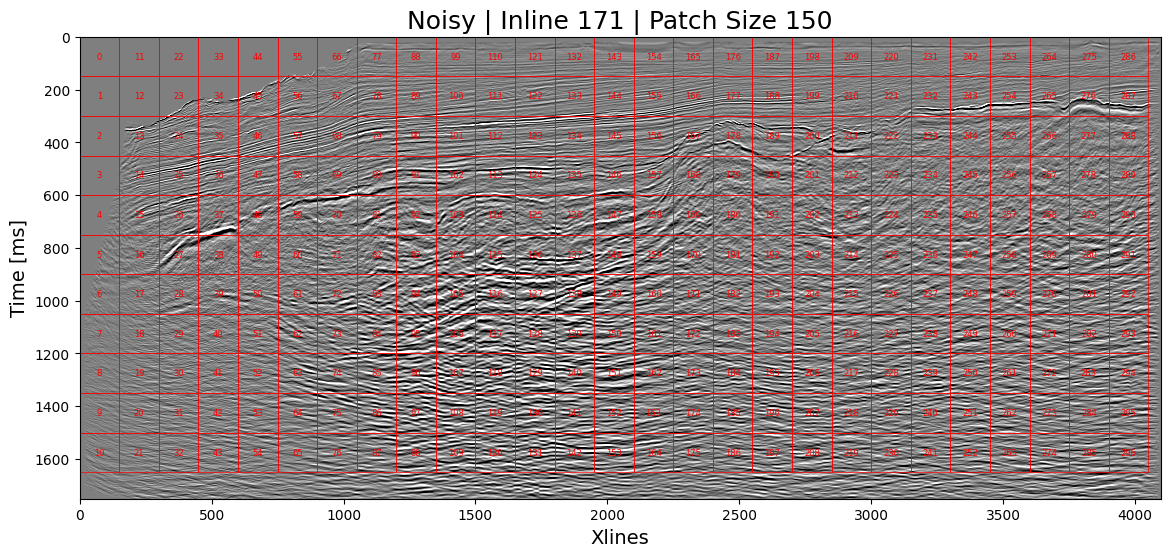

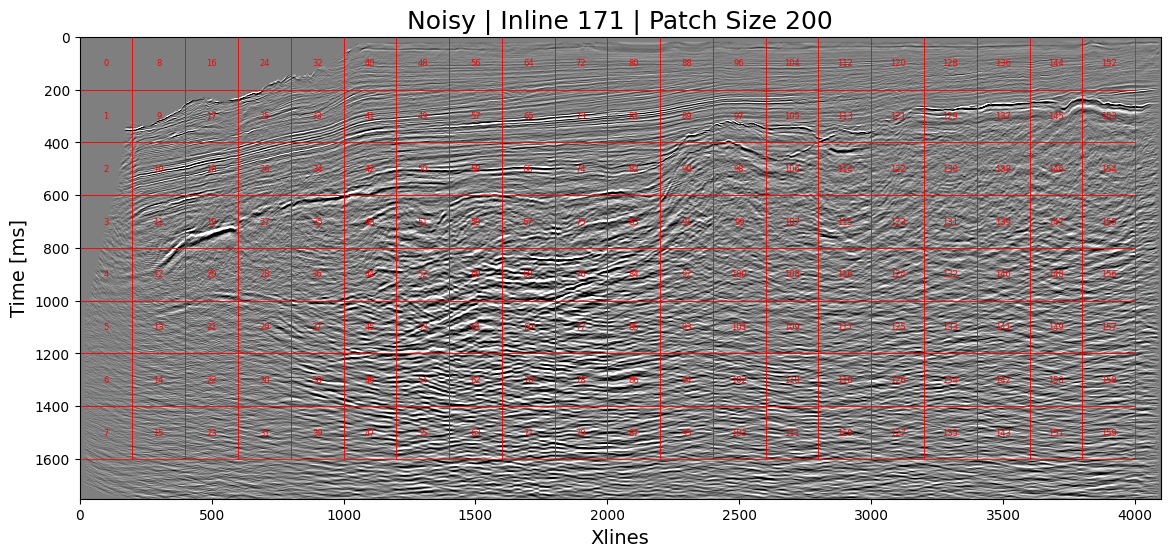

In [20]:
for patchSize in patchSizeList:
    xline_num_patch = cubeNoisy.shape[1] // patchSize
    time_num_patch = cubeNoisy.shape[2] // patchSize

    plt.figure(figsize=(20, 6))
    plt.imshow(cubeNoisy[iline, :, :].T, cmap='gray', aspect='equal', vmin=-amplitude_max, vmax=amplitude_max)

    for m in range(xline_num_patch):
        for n in range(time_num_patch):
            i = m * patchSize + patchSize // 2
            j = n * patchSize + patchSize // 2
            rect = plt.Rectangle((m * patchSize, n * patchSize), patchSize, patchSize, linewidth=0.5, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(i, j, str(m * time_num_patch + n), color='r', fontsize=6, ha='center', va='center')

    plt.xlabel('Xlines', fontsize=14)
    plt.ylabel('Time [ms]', fontsize=14)
    plt.title(f'Noisy | Inline {iline} | Patch Size {patchSize}', fontsize=18)    
    
    # Create directory if it does not exist
    directory = '/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/patches/noisy_patch_size_{}/'.format(patchSize)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plt.savefig(directory + '2D_iline_noisy_{}.png'.format(iline))

#### Xline

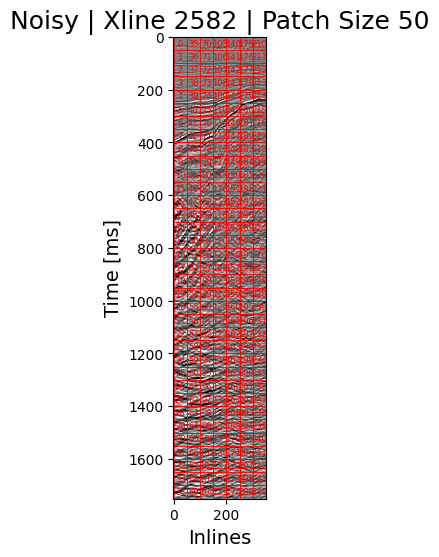

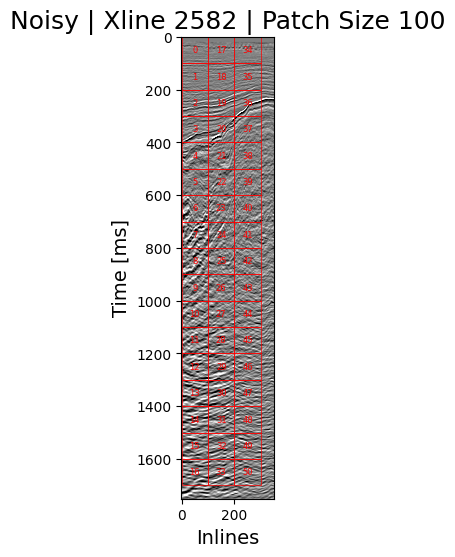

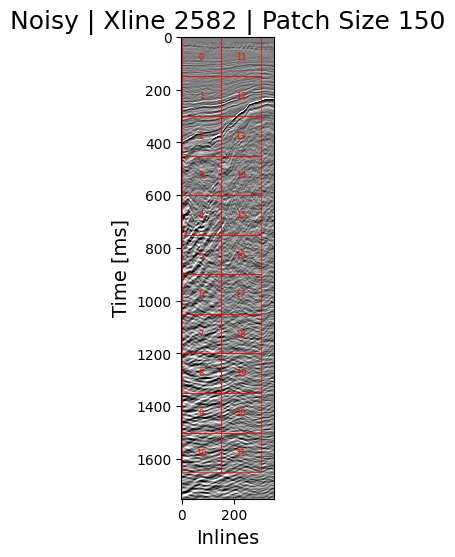

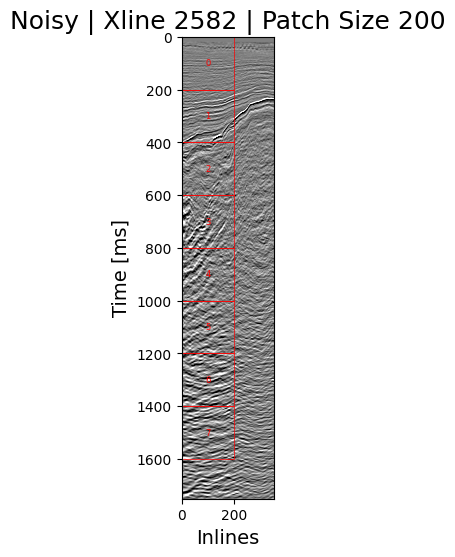

In [21]:
for patchSize in patchSizeList:
    iline_num_patch = cubeNoisy.shape[0] // patchSize
    time_num_patch = cubeNoisy.shape[2] // patchSize

    plt.figure(figsize=(20, 6))
    plt.imshow(cubeNoisy[:, xline, :].T, cmap='gray', aspect='equal', vmin=-amplitude_max, vmax=amplitude_max)

    for m in range(iline_num_patch):
        for n in range(time_num_patch):
            i = m * patchSize + patchSize // 2
            j = n * patchSize + patchSize // 2
            rect = plt.Rectangle((m * patchSize, n * patchSize), patchSize, patchSize, linewidth=0.5, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(i, j, str(m * time_num_patch + n), color='r', fontsize=6, ha='center', va='center')

    plt.xlabel('Inlines', fontsize=14)
    plt.ylabel('Time [ms]', fontsize=14)
    plt.title(f'Noisy | Xline {xline} | Patch Size {patchSize}', fontsize=18)

    # Create directory if it does not exist
    directory = '/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/patches/noisy_patch_size_{}/'.format(patchSize)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(directory + '2D_xline_noisy_{}.png'.format(xline))

#### Time

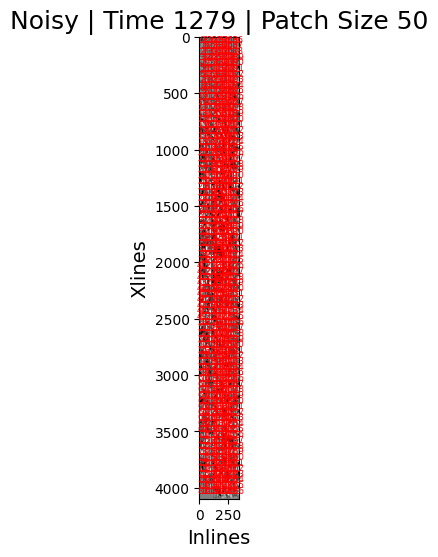

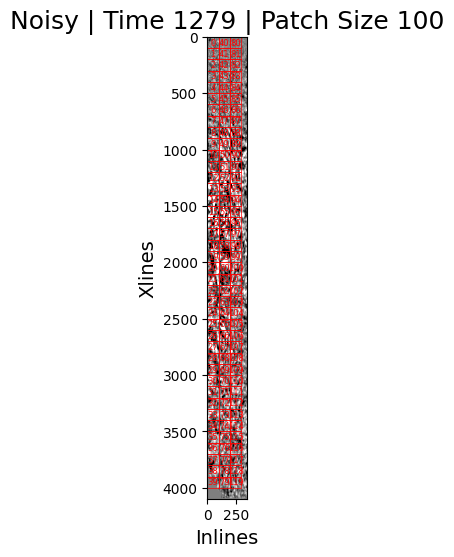

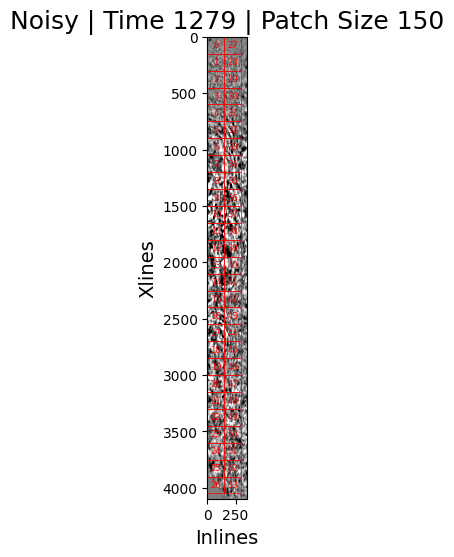

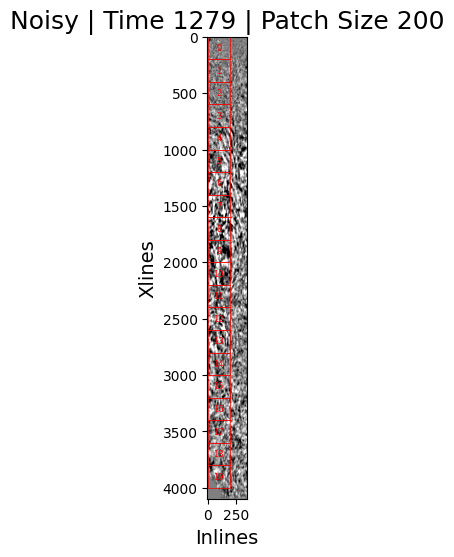

In [22]:
for patchSize in patchSizeList:
    iline_num_patch = cubeNoisy.shape[0] // patchSize
    xline_num_patch = cubeNoisy.shape[1] // patchSize

    plt.figure(figsize=(20, 6))
    plt.imshow(cubeNoisy[:, :, time].T, cmap='gray', aspect='equal', vmin=-amplitude_max, vmax=amplitude_max)

    for m in range(iline_num_patch):
        for n in range(xline_num_patch):
            i = m * patchSize + patchSize // 2
            j = n * patchSize + patchSize // 2
            rect = plt.Rectangle((m * patchSize, n * patchSize), patchSize, patchSize, linewidth=0.5, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(i, j, str(m * xline_num_patch + n), color='r', fontsize=6, ha='center', va='center')

    plt.xlabel('Inlines', fontsize=14)
    plt.ylabel('Xlines', fontsize=14)
    plt.title(f'Noisy | Time {time} | Patch Size {patchSize}', fontsize=18)

    # Create directory if it does not exist
    directory = '/home/roderickperez/DS_projects/autoencoders/images/Seismic/InforP/patches/noisy_patch_size_{}/'.format(patchSize)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(directory + '2D_time_noisy_{}.png'.format(time))

---

### Extract Patches

In [24]:
# Select a random value for the inline, crossline, time slice
random_iline = np.random.randint(0, cubeNoisy.shape[0])
random_xline = np.random.randint(0, cubeNoisy.shape[1])
random_time = np.random.randint(0, cubeNoisy.shape[2])

### Noisy Volume

#### Inline

In [25]:
for patchSize in patchSizeList:
    iline_num_patches = cubeNoisy.shape[0]
    xline_num_patches = cubeNoisy.shape[1] // patchSize
    time_num_patches = cubeNoisy.shape[2] // patchSize

    iline_noisy_patches = {}
    count = 0

    for i in range(iline_num_patches):
        for j in range(xline_num_patches):
            for k in range(time_num_patches):
                iline_start, iline_end = i, i + 1
                xline_start, xline_end = j * patchSize, (j + 1) * patchSize
                time_start, time_end = k * patchSize, (k + 1) * patchSize

                patch = cubeNoisy[iline_start:iline_end, xline_start:xline_end, time_start:time_end].squeeze()

                iline_noisy_patches[count] = patch
                count += 1
    # Construct the directory path
    dir_path = f'/home/roderickperez/DS_projects/autoencoders/data/InforPetrol/patches/patches_size_{patchSize}/noisy/inline_2D_noisy'
            
    # Save the individual patches as separate .npy arrays
    for i in range(len(iline_noisy_patches)):
        
        # Check if directory exists, if not then create it
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        
        # Save the .npy file in the directory
        np.save(dir_path + f'/inline_2D_noisy_{i}.npy', iline_noisy_patches[i])

#### Xline

In [ ]:
for patchSize in patchSizeList:
    iline_num_patches = cubeNoisy.shape[0] // patchSize
    xline_num_patches = cubeNoisy.shape[1]
    time_num_patches = cubeNoisy.shape[2] // patchSize

    xline_noisy_patches = {}
    count = 0

    for j in range(xline_num_patches):
        for i in range(iline_num_patches):
            for k in range(time_num_patches):
                iline_start, iline_end = i * patchSize, (i + 1) * patchSize
                xline_slice = j
                time_start, time_end = k * patchSize, (k + 1) * patchSize

                patch = cubeNoisy[iline_start:iline_end, xline_slice:xline_slice+1, time_start:time_end].squeeze()

                xline_noisy_patches[count] = patch
                count += 1
    # Construct the directory path
    dir_path = f'/home/roderickperez/DS_projects/autoencoders/data/InforPetrol/patches/patches_size_{patchSize}/noisy/xline_2D_noisy'
        

    # Save the individual patches as separate .npy arrays
    for i in range(len(xline_noisy_patches)):
        
        # Check if directory exists, if not then create it
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        
        # Save the .npy file in the directory
        np.save(dir_path + f'/xline_2D_noisy_{i}.npy', xline_noisy_patches[i])


#### Time

In [ ]:
for patchSize in patchSizeList:
    iline_num_patches = cubeNoisy.shape[0] // patchSize
    xline_num_patches = cubeNoisy.shape[1] // patchSize
    time_num_patches = cubeNoisy.shape[2]

    time_noisy_patches = {}
    count = 0

    for k in range(time_num_patches):
        for i in range(iline_num_patches):
            for j in range(xline_num_patches):
                iline_start, iline_end = i * patchSize, (i + 1) * patchSize
                xline_start, xline_end = j * patchSize, (j + 1) * patchSize
                time_slice = k

                patch = cubeNoisy[iline_start:iline_end, xline_start:xline_end, time_slice:time_slice+1].squeeze()

                time_noisy_patches[count] = patch
                count += 1
    # Construct the directory path
    dir_path = f'/home/roderickperez/Documents/DS_Projects_Ubuntu/Denoising_Seismic_AutoEncoder/data/InforPetrol/patches/patches_size_{patchSize}/noisy/time_2D_noisy/'
        
    # Save the individual patches as separate .npy arrays
    for i in range(len(time_noisy_patches)):
        
        # Check if directory exists, if not then create it
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        
        # Save the .npy file in the directory
        np.save(dir_path + f'/time_2D_noisy_{i}.npy', time_noisy_patches[i])

---

---